# Importing all necessary classes and libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from GS_algorithm_first_iteration import gsw_output
from GS_algorithm2 import *
from SLM_Control import *
from showSLMPreview import showSLMPreview
from dcam_live_capturing import *
from beam_locator import *
import time
from hamamatsu.dcam import copy_frame, dcam, Stream
from dcam_show_single_captured_image import *
import os
import matplotlib.patches as patches

# SLM Initialization

Make sure that the SLM Preview window is open

In [3]:
slm = SLMControler()

# Initialize camera and capture the background intensity 

### Camera Initialization

For debugging or if the camera initialization returns error. Try running the HCImageLive software to check if the camera can be detected and viewed. Try running the cell again after the software is closed.

Make sure that the HCImageLive software is closed since it can not run concurrently with the python code

### Background intensity

Block the coupling laser before you take the measurement

Data type of the background image:  uint16


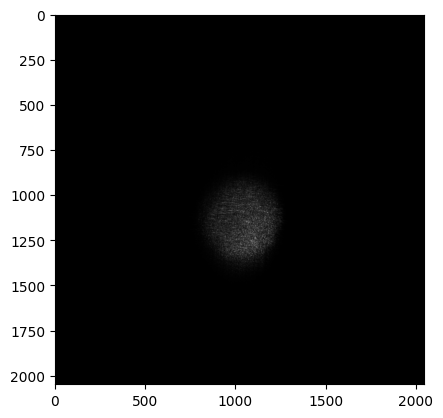

In [11]:
background = dcam_show_single_captured_image()

# print out the data type of the background image
print("Data type of the background image: ", background.dtype)

background = np.array(background)

# Displaying the background image
plt.imshow(background, cmap='gray')
plt.show()

# Beam Locating

### First iteration of GSW without feedback

This part is used to locate the beams using the beam locator class

Weight:  [0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
Part:  1


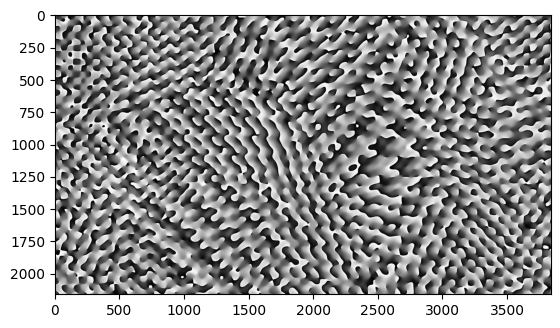

In [4]:
### Initilization ###
# for the light beams 
number_of_rows = 4
number_of_columns = 4

# for the phase pattern 
part_rows = 1
part_columns = 1
# to define a normal distribution of weights depending on the number of rows and columns

# weight = np.array([0.25, 0.25, 0.25, 0.25])

# weight = np.array([
#     0.04, 0.04, 0.04, 0.04, 0.04,
#     0.04, 0.04, 0.04, 0.04, 0.04,
#     0.04, 0.04, 0.04, 0.04, 0.04,
#     0.04, 0.04, 0.04, 0.04, 0.04,
#     0.04, 0.04, 0.04, 0.04, 0.04
# ])

# create an uniform weight matrix depending on the row and col numbers
weight = np.ones(number_of_rows * number_of_columns) / (number_of_rows * number_of_columns)

print("Weight: ", weight)

# since we are only using this part to get the LOCATION of the beams, we don't need to specify the weights
# weight = np.array([0.8, 0.1, 0.8, 0.1])
# the top two beams are brighter

# weight = np.array([0.1, 0.1, 0.8, 0.8])
# the left two are brighter -> so the first element represents the top right beam 
# the second element represents the bottom right beam
# the third element represents the top left beam
# the fourth element represents the bottom left beam

# weight = np.array([0.01, 0.5, 0.5, 0.7])

# beam waist size
w0 = 10

# distances between each light beams
interval = 50

# the error allowed for which the algorithm to start saving the phase patterns
# if the error is less than the error_allowed, the algorithm will save the phase pattern in the desired file location

Dim = np.array([part_rows, part_columns])
#####################

# size_real = np.array([1920, 1080]) 
# using the HOLOEYE GAEA-2, the resolution is 3840 x 2160
size_real = np.array([3840, 2160])
Overall_Pattern = np.zeros((2160, 3840), dtype=np.float64)

size_real = size_real / Dim 
size_real = size_real.astype(int)
temp = np.zeros(number_of_columns * number_of_rows)
temp[:len(weight)] = weight
weight_shaped = np.reshape(temp, (number_of_columns, number_of_rows))
weight_shaped = np.flipud(weight_shaped)

Pattern1 = np.zeros((2160, 3840), dtype=np.float64)

total_part_num = part_rows * part_columns

for part in range(1, total_part_num + 1):
    print("Part: ", part)

    # since we are only generating a total phase pattern that is used to locate the beams, we don't need to go through too many iterations to get the most accurate phase pattern for the best accuracy
    for iteration in range (0, 5):
        # since there is no feedback in this part, the balance is set to 0
        balance = 0
        if iteration == 0:
            [Pattern_part, phi] = gsw_output(size_real, weight_shaped, interval, number_of_rows, number_of_columns, w0, 0)
            Pattern_last = phi
        else:
            [Pattern_part, phi] = gs_iteration_modified(size_real, weight_shaped, interval, Pattern_last, balance, w0)
            Pattern_last = phi

    if part == 65: 
        part_65 = Pattern_part

    
    x = int(Dim[0] - 1 - np.mod(part - 1, Dim[0]))
    y = int(np.floor((part - 1) / Dim[0]))  

    start_x = x * size_real[0]
    end_x = (x+1) * size_real[0]
    start_y = y * size_real[1]
    end_y = (y+1) * size_real[1]
 
    Pattern1[start_y : end_y, start_x : end_x] = Pattern_part

# divide each value in Pattern by 2 * pi
Pattern1 = np.mod(Pattern1, 2 * np.pi)

# displaying the phase pattern
plt.imshow(Pattern1, cmap='gray')

### Run the beam locator to find the locations of all beams

Display the generated phase pattern and capture a single frame image which will then be used for the beam locator. The image is displayed for debugging purposes.

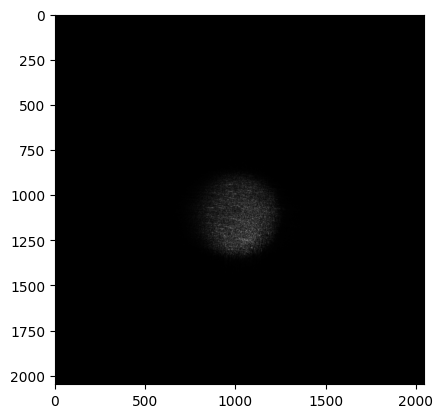

In [6]:
slm.display_data(Pattern1)

captured_image = dcam_show_single_captured_image()
captured_image = np.array(captured_image)
plt.imshow(captured_image, cmap='gray')

The cursors are color coded for clarity purposes. The red cursor is to be placed on the top left corner of the top left most beam, the orange cursor is to be placed at the bottom right corner of the top left most beam. The yellow cursor is to be placed on the top left corner of the top right most beam, and the green cursor is to be placed on the top left corner of the bottom left most beam.

In [7]:
captured_image = dcam_show_single_captured_image()
captured_image = np.array(captured_image)

# Check if an image was captured
if captured_image is not None:
    # # Create a resizable window
    # cv2.namedWindow("Captured Image", cv2.WINDOW_NORMAL)

    # # Display the captured image using OpenCV
    # cv2.imshow("Captured Image", captured_image)
    
    # while True:
    #     if cv2.waitKey(1) & 0xFF == ord('q') or cv2.getWindowProperty("Captured Image", cv2.WND_PROP_VISIBLE) < 1:
    #         break
    # cv2.destroyAllWindows()  # Close the window

    locator = beam_locator(captured_image, number_of_rows, number_of_columns)

    # Display image with crosshairs and allow user interaction
    locator.display_image_with_crosshairs()

    # Get cursor locations
    cursor_locations = locator.get_cursor_locations()

    locator.calculate_all_beam_locations()

    beam_corners = locator.beam_corners

    # store them in a file
    with open("beam_corners.txt", "w") as f:
        for loc in beam_corners:
            top_left, bottom_right = loc
            f.write(f"{top_left[0]}, {top_left[1]}, {bottom_right[0]}, {bottom_right[1]}\n")
else:
    print("No image captured.")

Cursor Locations: [(357, 278), (1548, 304), (436, 381), (305, 1496)]
Sorted Cursor Locations: [(357, 278), (1548, 304), (436, 381), (305, 1496)]
Calculations for Beam Diameter: 436 357 381 278
Beam Diameter: 129.80754985747168


To double check that all the beam corners have been calculated. these values can also be read in the beam_corner.txt file in the directory

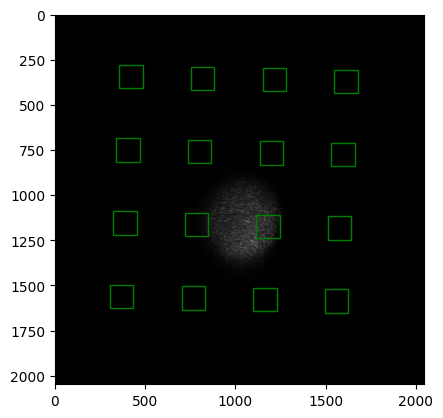

In [9]:
# take the captured image, and draw the rectangles around the beams using the beam corners 
fig, ax = plt.subplots()
ax.imshow(captured_image, cmap='gray')
for top_left, bottom_right in beam_corners:
            width = bottom_right[0] - top_left[0]
            height = bottom_right[1] - top_left[1]
            rect = patches.Rectangle(top_left, width, height, linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

### Function to measure the intensity of each beam

In [ ]:
captured_image = dcam_show_single_captured_image()
captured_image = np.array(captured_image)

image = captured_image - background

def measure_greyscale_intensity(image, beam_corners, beam_dim):
    """
    Measures the grayscale intensity inside the rectangles described by the coordinates in beam_corners.

    Parameters:
    image (numpy.ndarray): The input image.
    beam_corners (list): A list of tuples, where each tuple contains two pairs of coordinates
                         (top-left and bottom-right) of a beam.

    Returns:
    intensities (list): A list of average grayscale intensities for each beam.
    """
    intensities = np.zeros(beam_dim * beam_dim)

    # for top_left, bottom_right in beam_corners:
    #     x1, y1 = map(int, top_left)
    #     x2, y2 = map(int, bottom_right)
    #     roi = image[y1:y2, x1:x2]
    #     average_intensity = np.mean(roi)
    #     intensities.append(average_intensity)

    # corrected indexing for the beam corners

    top_left, bottom_right = beam_corners[0]
    x1, y1 = map(int, top_left)
    x2, y2 = map(int, bottom_right)
    roi = image[y1:y2, x1:x2]
    intensities[2] = np.mean(roi)

    top_left, bottom_right = beam_corners[1]
    x1, y1 = map(int, top_left)
    x2, y2 = map(int, bottom_right)
    roi = image[y1:y2, x1:x2]
    intensities[0] = np.mean(roi)

    top_left, bottom_right = beam_corners[2]
    x1, y1 = map(int, top_left)
    x2, y2 = map(int, bottom_right)
    roi = image[y1:y2, x1:x2]
    intensities[3] = np.mean(roi)

    top_left, bottom_right = beam_corners[3]
    x1, y1 = map(int, top_left)
    x2, y2 = map(int, bottom_right)
    roi = image[y1:y2, x1:x2]
    intensities[1] = np.mean(roi)

    return intensities

# for testing purposes
# Measure the grayscale intensity inside the rectangles described by the beam corners
measured_intensities = measure_greyscale_intensity(image, beam_corners)

print("Grayscale Intensities for Each Beam:")
for idx, intensity in enumerate(measured_intensities):
    print(f"Beam {idx + 1}: {intensity}")

In [12]:
import numpy as np

def get_reordered_indices(beam_dim):
    """
    Returns the indices for reordering the intensities based on the beam dimension.
    The desired order is: top-right, bottom-right, top-left, bottom-left for 2x2 and similar for larger dimensions.

    Parameters:
    beam_dim (int): Dimension of the light beam pattern (e.g., 2 for 2x2, 5 for 5x5).

    Returns:
    list: Reordered indices.
    """
    if beam_dim == 2:
        return [0, 2, 1, 3]  # top-right, bottom-right, top-left, bottom-left
    elif beam_dim == 5:
        return [0, 5, 10, 15, 20, 1, 6, 11, 16, 21, 2, 7, 12, 17, 22, 3, 8, 13, 18, 23, 4, 9, 14, 19, 24]
    elif beam_dim == 4:
        return [0, 4, 8, 12, 1, 5, 9, 13, 2, 6, 10, 14, 3, 7, 11, 15]


def measure_greyscale_intensity(image, beam_corners, beam_dim):
    """
    Measures the grayscale intensity inside the rectangles described by the coordinates in beam_corners.
    Reorders the intensities based on the desired order.

    Parameters:
    image (numpy.ndarray): The input image.
    beam_corners (list): A list of tuples, where each tuple contains two pairs of coordinates
                         (top-left and bottom-right) of a beam.
    beam_dim (int): Dimension of the light beam pattern (e.g., 2 for 2x2, 5 for 5x5).

    Returns:
    intensities (list): A list of average grayscale intensities for each beam.
    """
    intensities = np.zeros(beam_dim * beam_dim)

    for idx, (top_left, bottom_right) in enumerate(beam_corners):
        x1, y1 = map(int, top_left)
        x2, y2 = map(int, bottom_right)
        roi = image[y1:y2, x1:x2]
        intensities[idx] = np.mean(roi)

    # if beam_dim is 5, we want to first remove the 12th beam (center beam) and then reorder the intensities

    reordered_indices = get_reordered_indices(beam_dim)
    reordered_intensities = intensities[reordered_indices]

    return reordered_intensities

# Example usage
captured_image = dcam_show_single_captured_image()
captured_image = np.array(captured_image)

image = captured_image - background

beam_dim = 5

# Measure the grayscale intensity inside the rectangles described by the beam corners
measured_intensities = measure_greyscale_intensity(image, beam_corners, beam_dim)

print("Grayscale Intensities for Each Beam:")
for idx, intensity in enumerate(measured_intensities):
    print(f"Beam {idx}: {intensity}")


Grayscale Intensities for Each Beam:
Beam 0: 28635.031488492277
Beam 1: 30193.437396449703
Beam 2: 23249.08846153846
Beam 3: 29552.656691304608
Beam 4: 0.0
Beam 5: 29622.226774001192
Beam 6: 30206.13295857988
Beam 7: 30517.337686344665
Beam 8: 0.0
Beam 9: 0.0
Beam 10: 30044.601669648182
Beam 11: 29997.431484794277
Beam 12: 29812.353945075418
Beam 13: 0.0
Beam 14: 0.0
Beam 15: 29040.603869959737
Beam 16: 30251.39427549195
Beam 17: 30364.798270721527
Beam 18: 0.0
Beam 19: 0.0
Beam 20: 30005.113476446033
Beam 21: 29468.280059171597
Beam 22: 30595.62856290996
Beam 23: 0.0
Beam 24: 0.0


### Rescale the beam intensities

In [14]:
rescale = 3e-6

To double check if the rescale factor is appropriate. We want to the values appreared in the cell below to be higher than the desired weights

In [15]:
weight = np.ones(number_of_columns * number_of_rows) / (number_of_columns * number_of_rows)
# scale down the measured intensities
intensities = [intensity * rescale for intensity in measured_intensities]

# print out the intensities
print("Scaled Down Intensities:")
for idx, intensity in enumerate(intensities):
    print(f"Beam {idx + 1}: {intensity}")

Scaled Down Intensities:
Beam 1: 0.0417805853347711
Beam 2: 0.05573357151259681
Beam 3: 0.04172694382903637
Beam 4: 0.03618772277227723
Beam 5: 0.0
Beam 6: 0.05270416321929223
Beam 7: 0.03655406126850309
Beam 8: 0.04005100460739144
Beam 9: 0.0
Beam 10: 0.0
Beam 11: 0.05045104087834526
Beam 12: 0.03959879923536908
Beam 13: 0.05488776649348103
Beam 14: 0.0
Beam 15: 0.0
Beam 16: 0.05401060248995197
Beam 17: 0.05210164817174787
Beam 18: 0.061884495245564164
Beam 19: 0.0
Beam 20: 0.0
Beam 21: 0.04875918439368689
Beam 22: 0.04841090412704637
Beam 23: 0.04872900941084207
Beam 24: 0.0
Beam 25: 0.0


### Running the GSW algorithm

Take a close look at the std error as well as the mean error, we want the mean error to be negative as it has been shown that it gives better convergence. Negative mean error means that the overall measured intensities are higher than the desired values. Adjust the rescale factor to ensure that the measrued intensities are bit higher than the desired weights.

In [24]:
# Initialization
main_folder_path = r"C:\Users\sss190016\Box\Quantum Optics Lab\TeTON OANN Testbed\Data 2024\SLM phase pattern Aug 8 2024\12x12 Phase Pattern 4x4 Beam Full SLM1 Input"

number_of_rows = 4
number_of_columns = 4

part_rows = 1
part_columns = 1

# weight = np.array([0.25, 0.25, 0.25, 0.25])

# # 24 elements for the 5x5 beam pattern since we are not including the center beam
# weight = np.array([
#     0.04, 0.04, 0.04, 0.04, 0.04,
#     0.04, 0.04, 0.04, 0.04, 0.04,
#     0.04, 0.04, 0, 0.04, 0.04,
#     0.04, 0.04, 0.04, 0.04, 0.04,
#     0.04, 0.04, 0.04, 0.04, 0.04
# ])

# create an uniform weight matrix depending on the row and col numbers
weight = np.ones(number_of_rows * number_of_columns) / (number_of_rows * number_of_columns)

w0 = 10
interval = 50
Dim = np.array([part_rows, part_columns])

number_of_images = 10
# sum_intensities = np.zeros(25)  # Adjusted for 5x5 grid including the center

size_real = np.array([3840, 2160])
Overall_Pattern = np.zeros((2160, 3840), dtype=np.float64)
size_real = size_real / Dim
size_real = size_real.astype(int)
temp = np.zeros(number_of_columns * number_of_rows)
temp[:len(weight)] = weight
weight_shaped_t = np.reshape(temp, (number_of_columns, number_of_rows))
weight_shaped_t = np.flipud(weight_shaped_t)

error_allowed_for_file_writing = 0.0012
error_allowed_to_stop = 0.001
percent_error_threshold = 5


# Save the parameters in a text file
parameters_file_path = os.path.join(main_folder_path, "parameters.txt")

# Ensure the main folder path exists
os.makedirs(main_folder_path, exist_ok=True)

# Prepare the data to be saved
parameters = [
    ["Number of Rows", number_of_rows],
    ["Number of Columns", number_of_columns],
    ["Part Rows", part_rows],
    ["Part Columns", part_columns],
    ["Weight", weight],
    ["w0", w0],
    ["Interval", interval],
    ["Rescale", rescale],
    ["Number of Images", number_of_images],
    ["Error Allowed for File Writing", error_allowed_for_file_writing],
    ["Error Allowed to Stop", error_allowed_to_stop],
    ["Percent Error Threshold", percent_error_threshold]
]

# Save using np.savetxt
with open(parameters_file_path, 'w') as f:
    for param in parameters:
        f.write(f"{param[0]}: {param[1]}\n")

print(f"Parameters saved to {parameters_file_path}")

def pattern_placement(part, Pattern, Pattern_part):
    x = int(Dim[0] - 1 - np.mod(part - 1, Dim[0]))
    y = int(np.floor((part - 1) / Dim[0]))  

    start_x = x * size_real[0]
    end_x = (x+1) * size_real[0]
    start_y = y * size_real[1]
    end_y = (y+1) * size_real[1]
 
    Pattern[start_y : end_y, start_x : end_x] = Pattern_part
    return Pattern

def error_calculation(Wt, Wm, Wc, e):
    a = 0.8
    b = 0.2

    Wt = Wt[:len(Wm)]
    Wc = Wc[:len(Wm)]
    Wm = np.where(Wm < 0, 0.001, Wm)

    # print("ratio:", Wt / Wm)    

    temp = np.sqrt(a * Wt / Wm + (1 - a)) * Wc
    temp[Wt == 0] = 0
    W_next = temp
    
    # print("Wm:", Wm)
    # print("W_next:", W_next)

    if e == 0:
        e_next = -np.sum(Wt) + np.sum(Wm)
        e_next = np.sqrt(abs(e_next))
    else:
        e_next = (b * np.sum(Wm) / np.sum(Wt) + (1 - b)) * e

    return W_next, e_next



for part in range(1, number_of_rows * number_of_columns + 1):   
    print("Part:", part)
    Pattern = np.zeros((2160, 3840), dtype=np.float64)

    # Create a subfolder for the part number
    part_folder_path = os.path.join(main_folder_path, f"Part_{part}")
    os.makedirs(part_folder_path, exist_ok=True)

    # the starting calculated error as well the weight correction
    W_next = np.ones(number_of_columns * number_of_rows) 
    error = 1
    weight_shaped = weight_shaped_t

    std_errors = []
    mean_errors = []
    rmse_errors = []

    best_std_error = float('inf')
    best_mean_error = float('inf')
    best_rmse = float('inf')
    best_pattern = None

    for iteration in range(0, 81):
        try:
            if iteration == 0:
                [Pattern_part, phi] = gsw_output(size_real, weight_shaped, interval, number_of_rows, number_of_columns, w0, 0)
                Pattern_last = phi
                Pattern = pattern_placement(part, Pattern, Pattern_part)
                Pattern = np.mod(Pattern, 2 * np.pi)

                time.sleep(1)
                # sum_intensities = np.zeros(4)  # Reset the sum for each iteration
                # sum_captured_image = np.zeros_like(captured_image)

                # for _ in range(number_of_images):
                #     captured_image = dcam_show_single_captured_image()
                #     captured_image = np.array(captured_image)
                #     if captured_image is None:
                #         raise ValueError("Captured image is None")
                #     time.sleep(1)   
                #     # sum_captured_image += captured_image
                    
                #     captured_image = captured_image - background
                #     captured_image[captured_image < 0] = 0
                #     measured_intensities = measure_greyscale_intensity(captured_image, beam_corners, 2)
                #     sum_captured_image += captured_image
                #     # measured_intensities[12] = 0  # Skip the center beam

                #     sum_intensities += np.array([intensity * rescale for intensity in measured_intensities])

                # average_intensities = sum_intensities / number_of_images
                # print("Average Grayscale Intensities for Each Beam:", average_intensities)

                # W_next, error = error_calculation(weight, average_intensities, W_next, error)


                captured_image = dcam_show_single_captured_image()
                captured_image = np.array(captured_image)
                captured_image = captured_image - background
                captured_image[captured_image < 0] = 0
                average_intensities = measure_greyscale_intensity(captured_image, beam_corners, number_of_rows)
                average_intensities = np.array([intensity * rescale for intensity in average_intensities])
                # average_intensities[12] = 0  # Skip the center beam

                W_next, error = error_calculation(weight, average_intensities, W_next, error)

                print("Average Grayscale Intensities for Each Beam:", average_intensities)

                # decrease the length by 1 for the 5x5 pattern since we are not including the center beam 
                temp = np.zeros(number_of_columns * number_of_rows)
                temp[:len(weight)] = W_next
                weight_shaped = np.reshape(temp, (number_of_columns, number_of_rows))
                weight_shaped = np.flipud(weight_shaped)

                print("Calculated Error:", error)
                std_error = np.std(weight - average_intensities)
                print("std Error:", std_error)
                mean_error = np.mean(weight - average_intensities)
                print("Mean Error:", mean_error)
                rmse = np.sqrt(np.mean((weight - average_intensities) ** 2))
                print("RMSE:", rmse)
                std_errors.append(std_error)
                mean_errors.append(mean_error)
                rmse_errors.append(rmse)

            else:
                # # we want to first run a few iterations without the feedback 
                # if iteration < 6: 
                #     error = 0
                #     weight_shaped = weight_shaped_t

                [Pattern_part, phi] = gs_iteration_modified(size_real, weight_shaped, interval, Pattern_last, error, w0)
                Pattern_last = phi
                Pattern = pattern_placement(part, Pattern, Pattern_part)
                Pattern = np.mod(Pattern, 2 * np.pi)
                slm.display_data(Pattern)

                time.sleep(1)
                # sum_intensities = np.zeros(4)  # Reset the sum for each iteration
                # sum_captured_image = np.zeros_like(captured_image)

                # for _ in range(number_of_images):
                #     captured_image = dcam_show_single_captured_image()
                #     captured_image = np.array(captured_image)
                #     if captured_image is None:
                #         raise ValueError("Captured image is None")
                #     time.sleep(1)

                #     captured_image = captured_image - background
                #     captured_image[captured_image < 0] = 0
                #     measured_intensities = measure_greyscale_intensity(captured_image, beam_corners, 2)
                #     sum_captured_image += captured_image
                #     # measured_intensities[12] = 0  # Skip the center beam

                #     sum_intensities += np.array([intensity * rescale for intensity in measured_intensities])

                # average_intensities = sum_intensities / number_of_images
                # print("Average Grayscale Intensities for Each Beam:", average_intensities)

                # W_next, error = error_calculation(weight, average_intensities, W_next, error)
                captured_image = dcam_show_single_captured_image()
                captured_image = np.array(captured_image)
                captured_image = captured_image - background
                captured_image[captured_image < 0] = 0
                average_intensities = measure_greyscale_intensity(captured_image, beam_corners, number_of_rows)

                # rescale the intensities
                average_intensities = np.array([intensity * rescale for intensity in average_intensities])
                # average_intensities[12] = 0  # Skip the center beam

                W_next, error = error_calculation(weight, average_intensities, W_next, error)

                print("Average Grayscale Intensities for Each Beam:", average_intensities)

                # decrease the length by 1 for the 5x5 pattern since we are not including the center beam 
                temp = np.zeros(number_of_columns * number_of_rows)
                temp[:len(weight)] = W_next

                weight_shaped = np.reshape(temp, (number_of_columns, number_of_rows))
                weight_shaped = np.flipud(weight_shaped)

                print("Error:", error)
                std_error = np.std(weight - average_intensities)
                print("std Error:", std_error)
                mean_error = np.mean(weight - average_intensities)
                print("Mean Error:", mean_error)
                rmse = np.sqrt(np.mean((weight - average_intensities) ** 2))
                print("RMSE:", rmse)

                std_errors.append(std_error)
                mean_errors.append(mean_error)
                rmse_errors.append(rmse)

                percent_error = np.abs((average_intensities - weight) / weight) * 100
                # percent_error[12] = 0
                print("Percentage Error:", percent_error)

                if std_error < best_std_error:
                    best_std_error = std_error
                    best_mean_error = mean_error
                    best_rmse = rmse
                    best_pattern = np.copy(Pattern)

                if np.abs(mean_error) < error_allowed_to_stop and std_error < error_allowed_to_stop and rmse < error_allowed_to_stop and np.all(percent_error < percent_error_threshold):
                    final_file_path = os.path.join(part_folder_path, f"PhasePattern_Part_{part}_Final.txt")
                    np.savetxt(final_file_path, Pattern, fmt='%.16e')
                    print("Mean error and std error are below the threshold. Stopping the iteration.")
                    break

                if np.abs(mean_error) < error_allowed_for_file_writing and np.abs(std_error) < error_allowed_for_file_writing and rmse < error_allowed_for_file_writing:
                    file_path = os.path.join(part_folder_path, f"PhasePattern_Part_{part}_{iteration}.txt")
                    np.savetxt(file_path, Pattern, fmt='%.16e')
                    print(f"Phase pattern saved to {file_path}")

        except (TypeError, ValueError) as e:
            print(f"Error encountered during iteration {iteration}: {e}. Skipping this cycle.")
            continue

        fig, ax = plt.subplots()
        ax.imshow(captured_image, cmap='gray')

        for top_left, bottom_right in beam_corners:
            width = bottom_right[0] - top_left[0]
            height = bottom_right[1] - top_left[1]
            rect = patches.Rectangle(top_left, width, height, linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

        plt.title(f'Captured Image - Iteration {iteration}')
        plt.show()
        plt.pause(1)
        plt.close()

    # Save the best pattern as the final if threshold was not reached
    if best_pattern is not None:
        final_best_file_path = os.path.join(part_folder_path, f"PhasePattern_Part_{part}_Best.txt")
        np.savetxt(final_best_file_path, best_pattern, fmt='%.16e')
        print(f"Best phase pattern saved to {final_best_file_path}")

    # Plotting the errors
    iterations = range(0, len(std_errors))

    plt.figure()

    plt.plot(iterations, std_errors, label='Standard Error', marker='o')
    # plt.plot(iterations, mean_errors, label='Mean Error', marker='x')
    # plt.plot(iterations, rmse_errors, label='RMSE Error', marker='s')

    plt.xlabel('Iterations')
    plt.ylabel('Std Error')
    plt.title('Error Metrics vs Iterations')
    plt.legend()
    plt.grid(True)

    # Save the plot
    plot_file_path = os.path.join(part_folder_path, "error_plot.png")
    plt.savefig(plot_file_path)  # Save the plot before showing

    plt.show()  # Show the plot

    plt.close()  # Close the plot to free up memory

    print(f"Error plot saved to {plot_file_path}")

    # Save the best errors to a file
    best_errors_file_path = os.path.join(part_folder_path, "best_errors.txt")
    with open(best_errors_file_path, "w") as f:
        f.write(f"Best Standard Error: {best_std_error}\n")
        f.write(f"Best Mean Error: {best_mean_error}\n")
        f.write(f"Best RMSE Error: {best_rmse}\n")

    print(f"Best errors recorded in {best_errors_file_path}")


Parameters saved to C:\Users\sss190016\Box\Quantum Optics Lab\TeTON OANN Testbed\Data 2024\SLM phase pattern Aug 8 2024\12x12 Phase Pattern 4x4 Beam Full SLM1 Input\parameters.txt
Part: 1


KeyboardInterrupt: 

Average Grayscale Intensities for Each Beam: [0.07017683 0.0382962  0.04440406 0.03233127 0.04878074 0.04843707
 0.01935915 0.0193339  0.02674345 0.0410364  0.03438874 0.00319107
 0.         0.00815059 0.01311094 0.04081784 0.00546057 0.00525812
 0.01554172 0.05269595 0.05328847 0.03441209 0.0374852  0.04440406
 0.07315835]


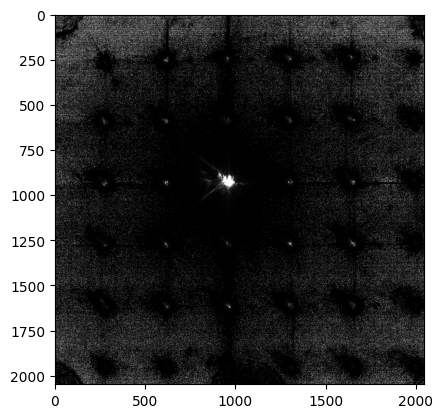

In [30]:
Pattern = np.zeros((2160, 3840), dtype=np.float64)
Pattern = pattern_placement(3, Pattern, Pattern_part)
Pattern = np.mod(Pattern, 2 * np.pi)
slm.display_data(Pattern)
captured_image = dcam_show_single_captured_image()
captured_image = np.array(captured_image)
if captured_image is None:
    raise ValueError("Captured image is None")

captured_image = captured_image - background

plt.imshow(captured_image, cmap='gray')

number_of_images = 10

time.sleep(1)
sum_intensities = np.zeros(25)  # Reset the sum for each iteration

for _ in range(number_of_images):
    captured_image = dcam_show_single_captured_image()
    captured_image = np.array(captured_image)
    if captured_image is None:
        raise ValueError("Captured image is None")
    time.sleep(1)

    captured_image = captured_image - background
    captured_image[captured_image < 0] = 0
    measured_intensities = measure_greyscale_intensity(captured_image, beam_corners, 5)
    measured_intensities[12] = 0  # Skip the center beam

    sum_intensities += np.array([intensity * rescale for intensity in measured_intensities])

average_intensities = sum_intensities / number_of_images
print("Average Grayscale Intensities for Each Beam:", average_intensities)


In [13]:
main_folder_path = r"C:\Users\sss190016\Box\Quantum Optics Lab\TeTON OANN Testbed\Data 2024\SLM phase pattern Aug 8 2024\12x12 Phase Pattern 4x4 Beam Full SLM1 Input"

part_folder = f"Part_53"
part_folder_path = os.path.join(main_folder_path, part_folder)

# Define the final phase pattern file name
final_file_name = f"PhasePattern_{part_folder}_Best.txt"
final_file_path = os.path.join(part_folder_path, final_file_name)

phase_pattern = np.loadtxt(final_file_path)

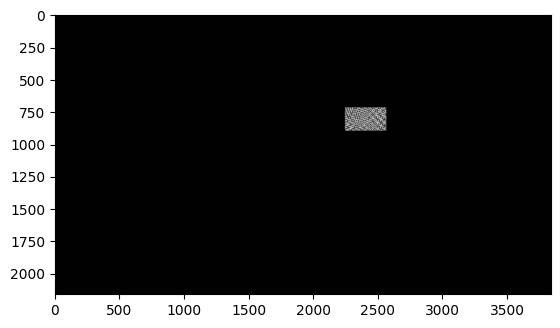

In [15]:
plt.imshow(phase_pattern, cmap='gray')

Grayscale Intensities for Each Beam:
Beam 1: 0.001834605142332415
Beam 2: 0.0013348898071625344
Beam 3: 0.0015693847566574841
Beam 4: 0.0009233746556473829
Beam 5: 0.002053801652892562
Beam 6: 0.15228624655647383
Beam 7: 0.18228571625344353
Beam 8: 0.14622957300275483
Beam 9: 0.07361100780532598
Beam 10: 0.0007396877869605143
Beam 11: 0.19352309458218547
Beam 12: 0.20063623507805325
Beam 13: 0.5836479224058769
Beam 14: 0.17487051882460972
Beam 15: 0.024126434802571164
Beam 16: 0.1762720707070707
Beam 17: 0.19223298668503214
Beam 18: 0.17469560146923785
Beam 19: 0.17849047750229569
Beam 20: 0.06896370064279156
Beam 21: 0.17661170798898068
Beam 22: 0.1717292401285583
Beam 23: 0.17492181588613406
Beam 24: 0.1410568572084481
Beam 25: 0.04371793847566575


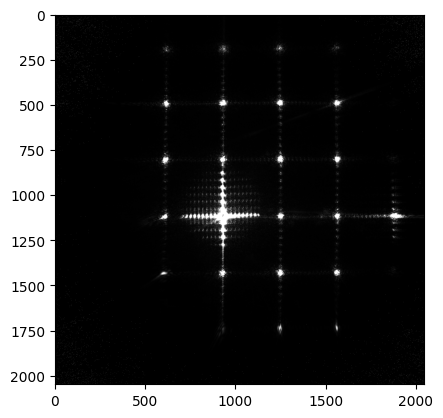

In [21]:
slm.display_data(phase_pattern)

time.sleep(1)

captured_image = dcam_show_single_captured_image()
captured_image = np.array(captured_image)

captured_image = captured_image - background

plt.imshow(captured_image, cmap='gray')

# for testing purposes
# Measure the grayscale intensity inside the rectangles described by the beam corners
measured_intensities = measure_greyscale_intensity(captured_image, beam_corners, 5)

print("Grayscale Intensities for Each Beam:")
for idx, intensity in enumerate(measured_intensities):
    print(f"Beam {idx + 1}: {intensity* rescale * 5}")

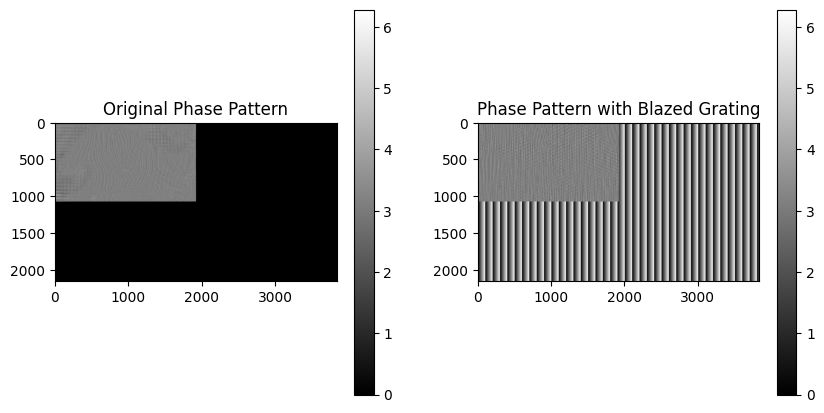

In [36]:

# Function to create a blazed grating
def create_blazed_grating(size, grating_period, orientation='horizontal'):
    """
    Create a blazed grating phase pattern.

    Args:
        size (tuple): Size of the phase pattern (height, width).
        grating_period (int): Period of the blazed grating.
        orientation (str): 'horizontal' or 'vertical' grating.

    Returns:
        np.ndarray: Blazed grating phase pattern.
    """
    if orientation == 'horizontal':
        x = np.linspace(0, 2 * np.pi, grating_period)
        blazed_grating = np.tile(x, (size[0], size[1] // grating_period + 1))
        blazed_grating = blazed_grating[:, :size[1]]
    else:
        y = np.linspace(0, 2 * np.pi, grating_period)
        blazed_grating = np.tile(y[:, np.newaxis], (1, size[1]))
        blazed_grating = np.tile(blazed_grating, (size[0] // grating_period + 1, 1))
        blazed_grating = blazed_grating[:size[0], :]

    return blazed_grating

# Add blazed grating to the phase pattern
def add_blazed_grating_to_pattern(phase_pattern, grating_period, orientation='horizontal'):
    """
    Add a blazed grating to the given phase pattern.

    Args:
        phase_pattern (np.ndarray): Original phase pattern.
        grating_period (int): Period of the blazed grating.
        orientation (str): 'horizontal' or 'vertical' grating.

    Returns:
        np.ndarray: Phase pattern with the added blazed grating.
    """
    blazed_grating = create_blazed_grating(phase_pattern.shape, grating_period, orientation)
    phase_pattern_with_grating = np.mod(phase_pattern + blazed_grating, 2 * np.pi)
    return phase_pattern_with_grating

# Assuming 'Pattern' is your phase pattern from the previous cell
grating_period = 100  # Adjust the period as needed
phase_pattern_with_grating = add_blazed_grating_to_pattern(phase_pattern, grating_period, orientation='horizontal')


# Display the phase patterns
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Pattern, cmap='gray')
plt.title('Original Phase Pattern')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(phase_pattern_with_grating, cmap='gray')
plt.title('Phase Pattern with Blazed Grating')
plt.colorbar()

plt.show()

In [40]:
slm.display_data(phase_pattern)

In [39]:
slm.display_data(phase_pattern_with_grating)

### Combining all phase patterns

In [ ]:
# Base directory containing the part folders
main_folder_path = r"C:\Users\sss190016\Box\Quantum Optics Lab\TeTON OANN Testbed\Data 2024\SLM phase pattern July 31 2024\2x2 Phase Pattern 5x5 Beam Uniform"

# List of part folders
part_folders = [f"Part_{i}" for i in range(1, 5)]

# Initialize the overall pattern with zeros
Overall_Pattern = np.zeros((2160, 3840), dtype=np.float64)

# Loop through each part folder
for part in range(1, 5):
    part_folder = f"Part_{part}"
    part_folder_path = os.path.join(main_folder_path, part_folder)
    
    # Define the final phase pattern file name
    final_file_name = f"PhasePattern_{part_folder}_Final.txt"
    final_file_path = os.path.join(part_folder_path, final_file_name)
    
    # Check if the final phase pattern file exists
    if os.path.exists(final_file_path):
        # Read the phase pattern from the file
        phase_pattern = np.loadtxt(final_file_path)
        plt.imshow(phase_pattern, cmap='gray')
        
        # Add the phase pattern to the overall pattern
        Overall_Pattern += phase_pattern
    else:
        print(f"Final phase pattern file not found in {part_folder_path}.")

# Display the final overall phase pattern using plt.imshow
plt.imshow(Overall_Pattern, cmap='gray')
plt.show()


### File Reading

In [ ]:
Overall_Pattern = np.zeros((2160, 3840), dtype=np.float64)


# Loop through each part folder
for part in range(1, 5):
    part_folder = f"Part_{part}"
    part_folder_path = os.path.join(main_folder_path, part_folder)
    
    # Define the final phase pattern file name
    final_file_name = f"PhasePattern_{part_folder}_Final.txt"
    final_file_path = os.path.join(part_folder_path, final_file_name)
    
    # Check if the final phase pattern file exists
    if os.path.exists(final_file_path):
        # Read the phase pattern from the file
        phase_pattern = np.loadtxt(final_file_path)
        
        # Add the phase pattern to the overall pattern
        Overall_Pattern += phase_pattern
    else:
        print(f"Final phase pattern file not found in {part_folder_path}.")

slm.display_data(Overall_Pattern)

time.sleep(1)

captured_image = dcam_show_single_captured_image()
captured_image = np.array(captured_image)

captured_image = captured_image - background

# for testing purposes
# Measure the grayscale intensity inside the rectangles described by the beam corners
measured_intensities = measure_greyscale_intensity(captured_image, beam_corners, 5)

print("Grayscale Intensities for Each Beam:")
for idx, intensity in enumerate(measured_intensities):
    print(f"Beam {idx + 1}: {intensity* rescale/4}")

In [ ]:
desired_weights = np.array([
    0.04, 0.04, 0.04, 0.04, 0.04,
    0.04, 0.04, 0.04, 0.04, 0.04,
    0.04, 0.04, 0, 0.04, 0.04,
    0.04, 0.04, 0.04, 0.04, 0.04,
    0.04, 0.04, 0.04, 0.04, 0.04
])

print("measured intensities:", measured_intensities * rescale / 4)

# Calculate the percent error
percent_error = np.abs((measured_intensities * rescale / 4 - desired_weights) / desired_weights) * 100

# Handle division by zero where desired_weights is 0
percent_error[desired_weights == 0] = np.nan  # Assign NaN where desired weights are zero

# Display the percent error
print("Percent Error for Each Beam:")
print(percent_error)

In [ ]:
slm.display_data(Overall_Pattern)

# put a sleep timer to make sure the SLM has enough time to display the pattern
time.sleep(1)

# to capture the beams better, we can use a higher exposure time 
captured_image = dcam_show_single_captured_image()
captured_image = np.array(captured_image)

# show the captured image using the plt function
plt.imshow(captured_image, cmap='gray')

# take the captured image, and draw the rectangles around the beams using the beam corners 
fig, ax = plt.subplots()
ax.imshow(captured_image, cmap='gray')
for top_left, bottom_right in beam_corners:
            width = bottom_right[0] - top_left[0]
            height = bottom_right[1] - top_left[1]
            rect = patches.Rectangle(top_left, width, height, linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)